In [1]:
%matplotlib inline

## Load packages
import os
import pickle
import datetime
import numpy as np
import pandas as pd
from numba import jit

from tsmodel import TimeSeriesModel

from scipy import stats
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import acf, pacf, ARMA
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pylab
import seaborn as sns

# Some plotting defaults
sns.set(style="ticks")
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams["figure.figsize"] = [10, 5]

# CCIWR class project
This code implements monte carlo simulation and prediction based on autoregressive processes.

tstamp
1931-01-01     704.800000
1931-02-01     442.200000
1931-03-01     698.900000
1931-04-01    1423.000000
1931-05-01    1049.000000
                 ...     
1997-08-01     662.100000
1997-09-01     670.210973
1997-10-01     601.300000
1997-11-01     476.900000
1997-12-01     304.300000
Name: discharge_cmps, Length: 804, dtype: float64

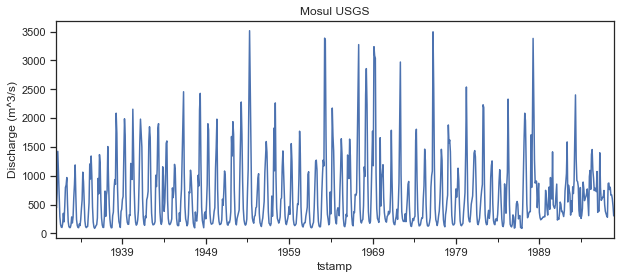

In [140]:
# Load the data
mosul_usgs = pd.read_csv("data/USGS/MosulMonthly1931-1997.csv", sep=';', index_col = 'year')
mosul_usgs = mosul_usgs.unstack().reset_index()
mosul_usgs = mosul_usgs.rename(columns={"level_0": "month", 0: 'discharge_cmps'})
mosul_usgs['day'] = np.repeat(1, len(mosul_usgs))
mosul_usgs['tstamp'] = pd.to_datetime(mosul_usgs[['day', 'month', 'year']], format="%d%m%Y")
mosul_usgs = mosul_usgs.sort_values(by='tstamp').set_index('tstamp')['discharge_cmps']
mosul_usgs = mosul_usgs.fillna(value=mosul_usgs.mean())

f, ax = plt.subplots()
ax = mosul_usgs.plot(title="Mosul USGS", figsize=(10,4))
ax.set_ylabel('Discharge (m^3/s)')
mosul_usgs

Calculate quantiles of the simulation distributions

# Monte carlo simulation for Mosul using USGS data

Text(0, 0.5, 'Discharge (m^3/s)')

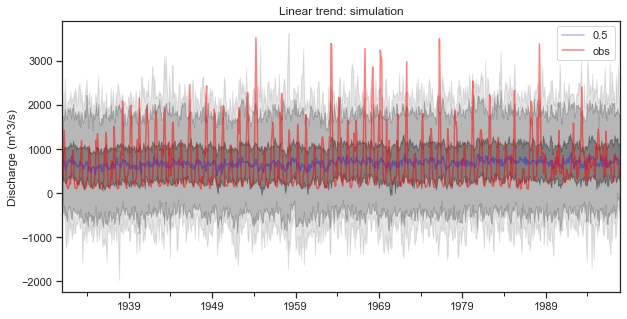

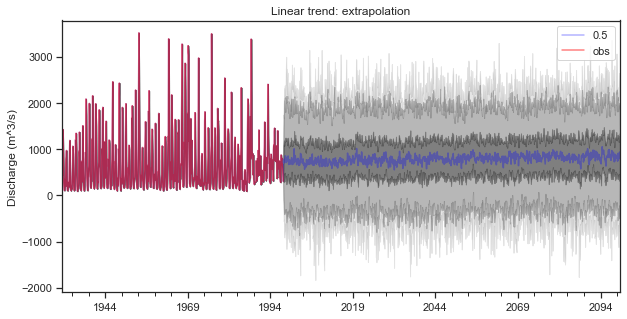

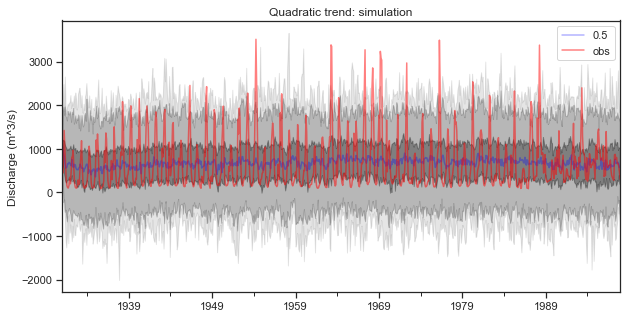

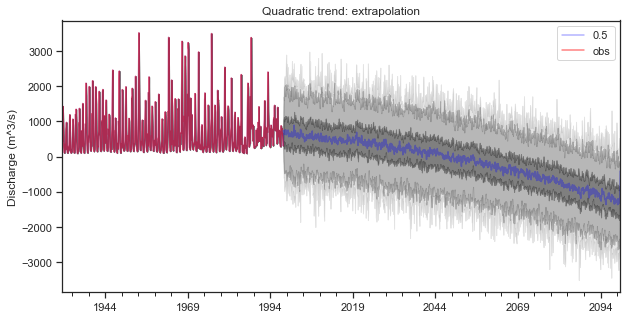

In [3]:
# run simulation
n_realisations = 100
until = '2099-12-31'
ts = mosul_usgs

# model with linear trend
model_mosul_usgs_linear = TimeSeriesModel(ts=ts)
model_mosul_usgs_linear = model_mosul_usgs_linear.fit(ar_order=1, pdeg=1)
model_mosul_usgs_linear = model_mosul_usgs_linear.monte_carlo(n=n_realisations)
model_mosul_usgs_linear = model_mosul_usgs_linear.extrapolate(until=until, n=n_realisations)

# model with quadratic trend
model_mosul_usgs_quadratic = TimeSeriesModel(ts=ts)
model_mosul_usgs_quadratic = model_mosul_usgs_quadratic.fit(ar_order=1, pdeg=2)
model_mosul_usgs_quadratic = model_mosul_usgs_quadratic.monte_carlo(n=n_realisations)
model_mosul_usgs_quadratic = model_mosul_usgs_quadratic.extrapolate(until=until, n=n_realisations)

# plots
ax = model_mosul_usgs_linear.plot(what='sim')
ax.set_title("Linear trend: simulation")
ax.set_ylabel("Discharge (m^3/s)")

ax = model_mosul_usgs_linear.plot(what='extrp')
ax.set_title("Linear trend: extrapolation")
ax.set_ylabel("Discharge (m^3/s)")

ax = model_mosul_usgs_quadratic.plot(what='sim')
ax.set_title("Quadratic trend: simulation")
ax.set_ylabel("Discharge (m^3/s)")

ax = model_mosul_usgs_quadratic.plot(what='extrp')
ax.set_title("Quadratic trend: extrapolation")
ax.set_ylabel("Discharge (m^3/s)")

# Using the simulation for Mosul based on USGS data to infer a simulation set at Ilisu

In [4]:
# crude conversion based on philips report, but probably the best we can do within the scope of the project
# Ilisu dam flows = 85% of Mosul dam flows in an undisturbed flow regime upstream of Mosul dam
mosul2ilisu = 0.85

# simulation
model_ilisu_usgs_linear_simulation = model_mosul_usgs_linear.simulation * mosul2ilisu
model_ilisu_usgs_quadratic_simulation = model_mosul_usgs_quadratic.simulation * mosul2ilisu

# extrapolation
model_ilisu_usgs_linear_extrapolation = model_mosul_usgs_linear.extrapolation * mosul2ilisu
model_ilisu_usgs_quadratic_extrapolation = model_mosul_usgs_quadratic.extrapolation * mosul2ilisu

Negative discharge doesn't make a whole lot of sense. Set values < 0 to 0.

In [5]:
model_mosul_usgs_linear.extrapolation = model_mosul_usgs_linear.extrapolation.where(model_mosul_usgs_linear.extrapolation > 0., 0.)
model_ilisu_usgs_linear_extrapolation = model_ilisu_usgs_linear_extrapolation.where(model_ilisu_usgs_linear_extrapolation > 0., 0.)

Store 100 extrapolations each

In [6]:
model_mosul_usgs_linear.extrapolation.to_csv("data/monte_carlo/model_mosul_usgs_linear.csv")
model_ilisu_usgs_linear_extrapolation.to_csv("data/monte_carlo/model_ilisu_usgs_linear.csv")

Calculate quantiles 

In [7]:
quantiles = [0., 0.025, 0.25, 0.5, 0.75, 0.975, 1.]
quantiles_mosul_usgs_linear = model_mosul_usgs_linear.extrapolation.quantile(q=quantiles, axis=1).T
quantiles_ilisu_usgs_linear = model_ilisu_usgs_linear_extrapolation.quantile(q=quantiles, axis=1).T

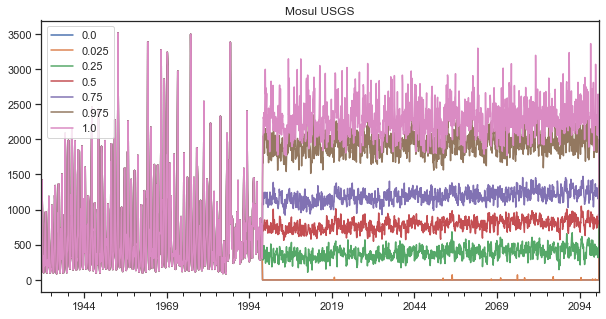

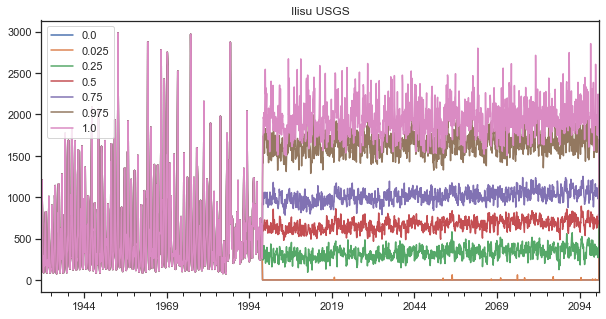

In [8]:
quantiles_mosul_usgs_linear.plot(title="Mosul USGS")
quantiles_ilisu_usgs_linear.plot(title="Ilisu USGS")

In [9]:
quantiles_mosul_usgs_linear.to_csv("data/monte_carlo/quantiles_mosul_usgs_linear.csv")
quantiles_ilisu_usgs_linear.to_csv("data/monte_carlo/quantiles_ilisu_usgs_linear.csv")

## Experimental: shifts in discharge seasonality
Does it shift if we go further into the future due to the impact of the extrapolated trend? (it should!)
If yes, how?

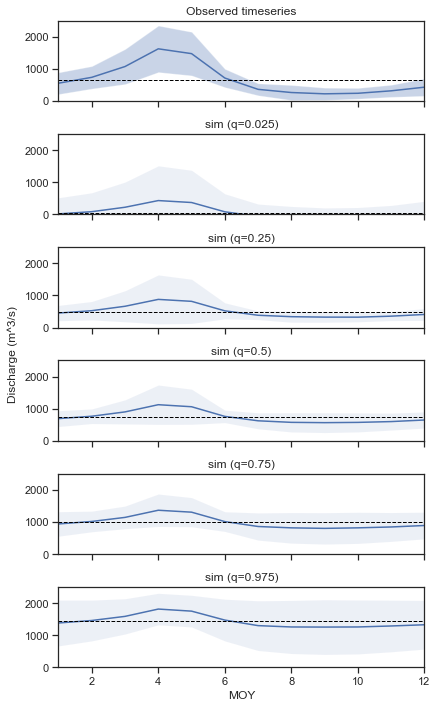

In [139]:
sns.set(style="ticks")
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fig, axes = plt.subplots(nrows=len(quantiles)+1, sharex=True, sharey=True, figsize=(6,10))

# plot observations
ts_obs = model_mosul_usgs_linear.ts
climat_obs_mean = ts_obs.groupby(ts_obs.index.month).mean()
climat_obs_mean.name = "obs"
climat_obs_sd = ts_obs.groupby(ts_obs.index.month).std()
climat_obs_mean.plot(ax = axes[0])
axes[0].axhline(climat_obs_mean.mean(), linestyle="--", color="black", linewidth=1)
axes[0].fill_between(climat_obs_mean.index.values,
                climat_obs_mean - climat_obs_sd,
                climat_obs_mean + climat_obs_sd,
                alpha = 0.3)
axes[0].set_title("Observed timeseries")

# plot simulations
ts_extrp = model_mosul_usgs_linear.quantiles
for q, ax in zip(quantiles, axes[1:]):
    ts_extrp_q = ts_extrp[q]
    climat_extrp_mean = ts_extrp_q.groupby(ts_extrp.index.month).mean()
    climat_extrp_sd = ts_extrp_q.groupby(ts_extrp.index.month).std()
    #climat_extrp_mean.name = "sim (q={})".format(q)
    
    # plot
    climat_extrp_mean.plot(ax = ax)
    ax.fill_between(climat_extrp_mean.index.values,
                    climat_extrp_mean - climat_extrp_sd,
                    climat_extrp_mean + climat_extrp_sd,
                    alpha = 0.1)
    ax.axhline(climat_extrp_mean.mean(), linestyle="--", color="black", linewidth=1)
    ax.set_title("sim (q={})".format(q))

# general
for ax in axes:
    ax.set_ylim(0.)
    ax.set_xlim(1,12)
axes[-1].set_xlabel("MOY")

fig.text(-0.01, 0.5, 'Discharge (m^3/s)', va='center', rotation='vertical')
plt.tight_layout()

comparison of seasonality of the first vs the last 30 years

In [136]:
# observations
ts_obs = ts_obs
climat_obs_mean = ts_obs.groupby(ts_obs.index.month).mean()
climat_obs_mean.name = "observed"
climat_obs_sd = ts_obs.groupby(ts_obs.index.month).std()

# simulations
q = 0.5
ts_extrp = ts_extrp
climat_extrp_mean = ts_extrp.groupby(ts_extrp.index.month).mean()
climat_extrp_sd = ts_extrp.groupby(ts_extrp.index.month).std()
climat_extrp_mean.name = "simulated"

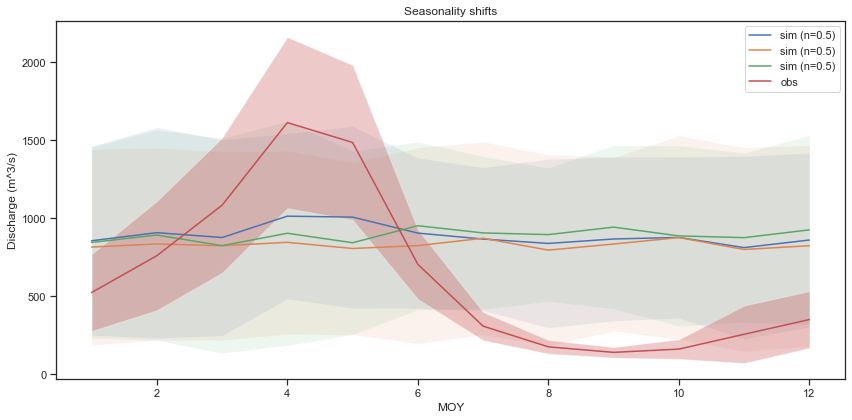

In [137]:
fig, ax = plt.subplots(figsize=(12,6))

# simulations
ts_extrp = model_mosul_usgs_linear.extrapolation['2066-01-31':'2099-12-31']
for n in [1, 50, 100]:
    ts_extrp_q = ts_extrp[n]
    climat_extrp_mean = ts_extrp_q.groupby(ts_extrp.index.month).mean()
    climat_extrp_sd = ts_extrp_q.groupby(ts_extrp.index.month).std()
    climat_extrp_mean.name = "sim (n={})".format(q)
    
    # plot
    climat_extrp_mean.plot(ax = ax)
    ax.fill_between(climat_extrp_mean.index.values,
                    climat_extrp_mean - climat_extrp_sd,
                    climat_extrp_mean + climat_extrp_sd,
                    alpha = 0.1)
    
# observations from the first 30 years
ts_obs = model_mosul_usgs_linear.ts['1931-01-01':'1961-01-01']
climat_obs_mean = ts_obs.groupby(ts_obs.index.month).mean()
climat_obs_mean.name = "obs"
climat_obs_sd = ts_obs.groupby(ts_obs.index.month).std()

# plot
climat_obs_mean.plot(ax = ax)
ax.fill_between(climat_obs_mean.index.values,
                climat_obs_mean - climat_obs_sd,
                climat_obs_mean + climat_obs_sd,
                alpha = 0.3)

# general
ax.set_xlabel("MOY")
ax.set_ylabel("Discharge (m^3/s)")
ax.set_title("Seasonality shifts")

plt.legend()
plt.tight_layout()

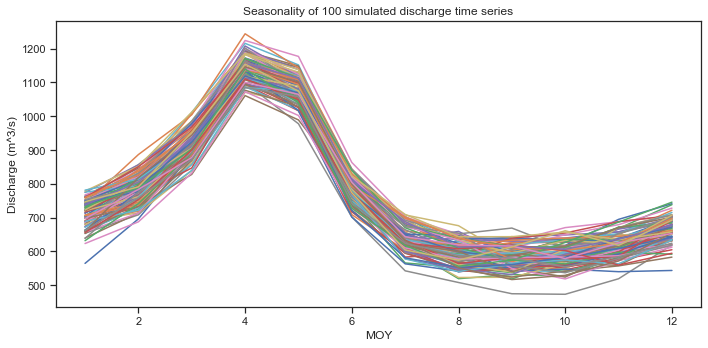

In [142]:
f, ax = plt.subplots()
for n in range(1, 100):
    ts = model_mosul_usgs_linear.extrapolation[n]
    ts_seas = ts.groupby(ts.index.month).mean()
    ts_seas.plot(ax=ax)
    
ax.set_xlabel("MOY")
ax.set_ylabel("Discharge (m^3/s)")
ax.set_title("Seasonality of 100 simulated discharge time series")
plt.tight_layout()